In [20]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch 
import torch.nn as nn

Getting dimensions right, how to make sure you can element wise add to the residual function the shortcut

In [29]:
x = torch.randn(1,3,224,224)
conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2)
x = conv1(x)
print("Input gets downsized after 7x7 64 channel conv: ",x.shape)
pooling = nn.MaxPool2d(3,stride=2)
x = pooling(x)
x.shape #64, 54x54

Input gets downsized after 7x7 64 channel conv:  torch.Size([1, 64, 109, 109])


torch.Size([1, 64, 54, 54])

In [30]:
conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3) 
x_old = conv2(x)
print("Input gets downsized AGAIN by 7x7 64 channel convrs",x.shape)
#repeat this convolution 5 more times with the same number of channels but
#reduces dimensions

Input gets downsized AGAIN by 7x7 64 channel convrs torch.Size([1, 64, 54, 54])


Now lets increase the number of dimensions:

From 64 -> 128, so when we add the input to the residual, we need to increase channels


In [31]:
conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2)
x_new = conv3(x_old)
print("old shape:",x_old.shape, "\nnew shape:",x_new.shape)

old shape: torch.Size([1, 64, 52, 52]) 
new shape: torch.Size([1, 128, 25, 25])


we need to add x_old to x_new, but we dont have the same dimensions in channels, thus we are going to increase the channels using 1d convs

In [37]:
x_old.shape

torch.Size([1, 64, 52, 52])

In [43]:
conv_modifier = nn.Conv2d(in_channels=x_old.shape[1],out_channels=x_new.shape[1],kernel_size=1)
x_old_modified = conv_modifier(x_old)
x_old_modified.shape

torch.Size([1, 128, 52, 52])

# Projections

In [53]:
class ShortcutProjection(nn.Module):
    def __init__(self,in_channels:int,out_channels:int,stride:int):
        
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=1,stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self,x:torch.Tensor):
        return self.bn(self.conv(x))

In [57]:
x_old.shape[1],x_new.shape[1]

(64, 128)

In [59]:
shortcut1 = ShortcutProjection(in_channels=x_old.shape[1],out_channels=x_new.shape[1],stride=1)
x_old_mod2 = shortcut1(x_old)
x_old_mod2.shape

torch.Size([1, 128, 52, 52])

First conv and maxpool initial operations
1. to fit the desired input shape of 112 to the first conv1 operation , we need to do padding of 3 to the first conv
2. To get 56x56 for teh conv2_x we need a max pool of 3x3 stride 2 and padding 1

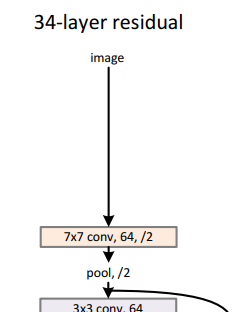
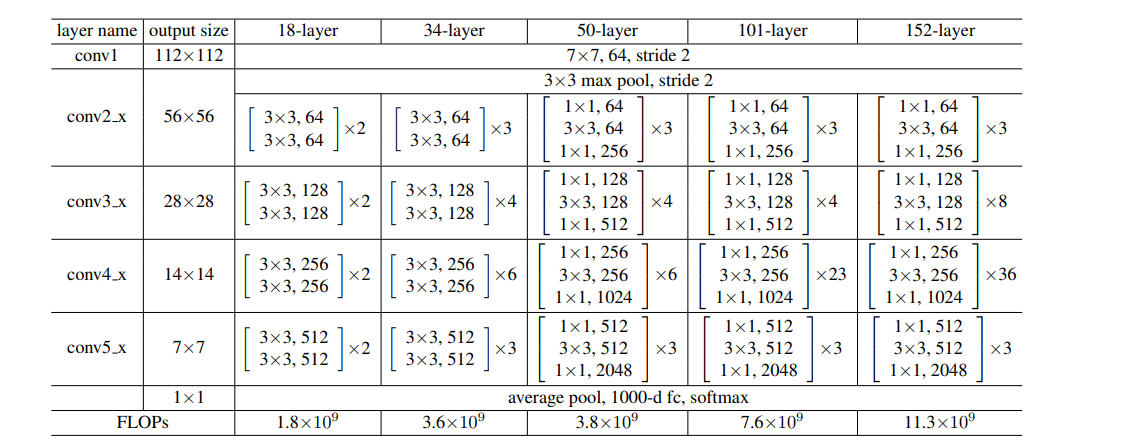

In [3]:
x = torch.randn(1,3,224,224)
conv1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3)
out_conv1 = conv1(x)
out_conv1.shape

torch.Size([1, 64, 112, 112])

In [9]:
pool1 = nn.MaxPool2d(3,2,padding=1)
out_pool1 = pool1(out_conv1)
out_pool1.shape

torch.Size([1, 64, 56, 56])

Now lets code the first block dimensions:
- to keep the 56x56 shape we need to pad 1 

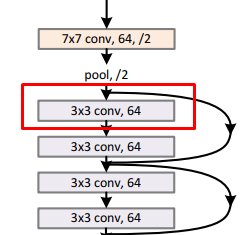
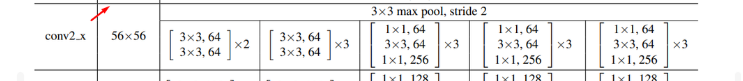

In [12]:
conv2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
out_conv2 = conv2(out_pool1)
out_conv2.shape


torch.Size([1, 64, 56, 56])

Now pass one more 3x3 conv with 64 filters 

In [13]:
conv2_2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,padding=1)
out_conv2_2 = conv2_2(out_conv2)
out_conv2_2.shape

torch.Size([1, 64, 56, 56])

# testing resnet implementation


In [21]:
from resnet import ResNetBase

In [22]:
n_blocks = [2,3]
n_channels = [64,128]
Resnet = ResNetBase(n_blocks=n_blocks,n_channels=n_channels)


In [25]:
x = torch.rand(1,3,224,224)
Resnet(x).shape

torch.Size([1, 128, 28, 28])